In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

In [2]:
x_data = pd.read_excel("All features.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [3]:
y_data = pd.read_csv("Target.csv", usecols=[1])
y_data

,FEaverage CO
0,14.760128
1,18.144924
2,20.750142
3,19.887920
4,21.001702
...,...
77,6.013192
78,3.219462
79,2.026439
80,18.885723


In [4]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [5]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [6]:
num_cores = multiprocessing.cpu_count()

In [8]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) 
variate=list(range(x_train.shape[1]))   
selected=[]   
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  

while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  
        current_variate = selected+[i]   
        current_x_train = x_train[:, current_variate]   
        current_x_test = x_test[:, current_variate]   
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  
    selected.append(best_candidate_index)  
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])


In [9]:
selected

[179,
 158,
 201,
 173,
 243,
 232,
 84,
 107,
 191,
 253,
 304,
 94,
 22,
 69,
 241,
 190,
 219,
 147,
 256,
 246,
 23,
 58,
 169,
 142,
 93,
 242,
 57,
 251,
 50,
 27,
 237,
 249,
 68,
 51,
 73,
 234,
 14,
 67,
 0,
 83,
 126,
 148,
 79,
 225,
 198,
 269,
 153,
 240,
 295,
 104,
 177,
 102,
 45,
 59,
 1,
 250,
 160,
 61,
 2,
 4,
 6,
 180,
 9,
 216,
 11,
 13,
 15,
 16,
 18,
 20,
 196,
 26,
 33,
 35,
 36,
 37,
 39,
 254,
 40,
 41,
 43,
 183,
 47,
 53,
 56,
 17,
 280,
 268,
 159,
 101,
 46,
 303,
 25,
 136,
 60,
 62,
 110,
 222,
 163,
 98,
 90,
 52,
 118,
 233,
 167,
 96,
 100,
 19,
 181,
 302,
 168,
 217,
 21,
 187,
 231,
 276,
 7,
 152,
 224,
 288,
 182,
 298,
 218,
 278,
 128,
 228,
 139,
 113,
 184,
 42,
 283,
 123,
 30,
 134,
 193,
 85,
 150,
 131,
 87,
 77,
 279,
 195,
 165,
 141,
 161,
 174,
 70,
 300,
 10,
 44,
 80,
 5,
 192,
 55,
 81,
 72,
 76,
 252,
 301,
 282,
 255,
 223,
 105,
 108,
 78,
 144,
 91,
 197,
 95,
 207,
 130,
 121,
 162,
 89,
 29,
 146,
 189,
 291,
 66,
 145,
 124

In [10]:
train_mse_list

[0.03689112851872299,
 0.03193566396627815,
 0.030092912758958555,
 0.02842007981180273,
 0.027335319539312185,
 0.024042904610180247,
 0.020473218117096105,
 0.018823224658866926,
 0.01816893446275944,
 0.017943684323057103,
 0.018032680221433454,
 0.0180348495926894,
 0.018293502601924562,
 0.018470722100608506,
 0.01850905100839009,
 0.01875790881035501,
 0.018733656208418818,
 0.018630547854127703,
 0.018641677108429473,
 0.0187104961634974,
 0.01883995280013539,
 0.018978138032582713,
 0.01878903974965903,
 0.017789582275733788,
 0.017687419558946156,
 0.017785354827384713,
 0.017796831346706097,
 0.017841215405890086,
 0.01680592320704491,
 0.01664201055312882,
 0.01676000302526838,
 0.016833804530330516,
 0.016800051115275803,
 0.01686057118371062,
 0.016670018035798442,
 0.01672417370473447,
 0.0167956005104195,
 0.01680710541333557,
 0.0168583685784329,
 0.016384598809416256,
 0.016407119576775066,
 0.016401684553353873,
 0.016296743485073817,
 0.016168069409719696,
 0.0162516

In [11]:
val_mse_list

[0.04124965370870033,
 0.03800751626610581,
 0.03696543982422525,
 0.03541704267700206,
 0.03570171765655056,
 0.03539912158158838,
 0.03381146770650131,
 0.03265711949028398,
 0.03077069532916188,
 0.029564209373383794,
 0.02930957171272385,
 0.029010381166621253,
 0.028968975157028315,
 0.028798711208822565,
 0.028841083787247833,
 0.028473651417180633,
 0.02846304149715937,
 0.02835916762871704,
 0.027938208719043532,
 0.027678763783207976,
 0.027400129785892895,
 0.027240925349243394,
 0.02703440202206146,
 0.02687090091958741,
 0.026564607776159634,
 0.02632241480591891,
 0.026117467538666457,
 0.02600098666245713,
 0.025915986270864482,
 0.0257003676418176,
 0.025659060371546992,
 0.025677020935623802,
 0.025654782191719044,
 0.025648550496601547,
 0.025710955356380627,
 0.025772080001879593,
 0.025875857024593628,
 0.025944054601258683,
 0.02601699082087952,
 0.026051056563008317,
 0.02591708661381247,
 0.02587700850288215,
 0.025750488199994336,
 0.025750445198573335,
 0.025753

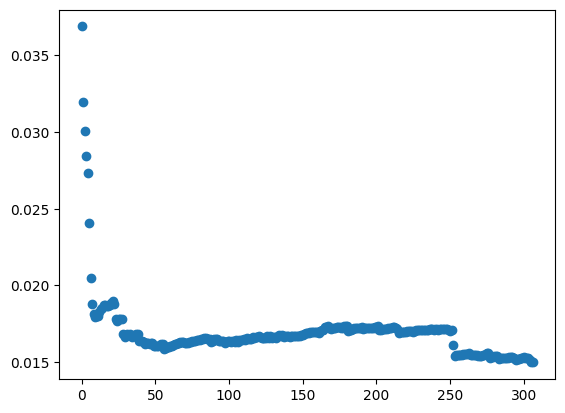

In [12]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

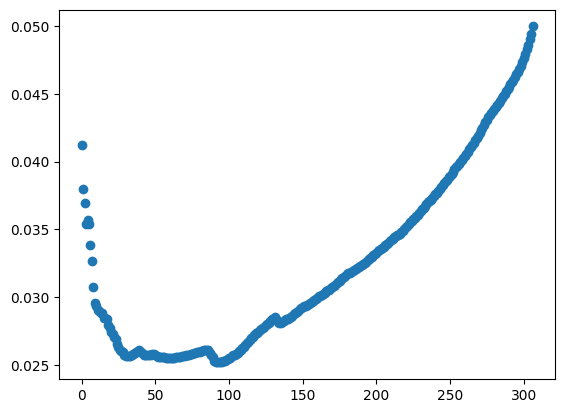

In [13]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [7]:

min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

91
0.02516433599562908


In [9]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Conju-Strut Wiener Index (Max-Conju)
NumAromaticRings
Fun_PEOE-Charge_Mean
Full-Mol Wiener Index
Conju_PEOE-Charge_Max
Mid-Fun_LogP_Delta
Chi2v
PEOE_VSA9
Atom_MR_Max
Occupied Orbitals
Atom1_ALIE Min value
PEOE_VSA1
Alcohol
ExactMolWt
Conju_LogP_Std
Atom_LogP_Max
Mid-Fun_PEOE-Charge_Mean
VSA_EState8
LUMO
Conju_PEOE-Charge_Min
Althoxyl
Sulfon
Num of Conju-Strut
VSA_EState3
LabuteASA
Conju_MR_Std
Nitro
Conju_MR_Delta
Arylchloride
Primary_arom_amine
Conju_PEOE-Charge_Mean
Conju_PEOE-Charge_Delta
HeavyAtomMolWt
Arylfluoride
MaxAbsPartialCharge
Conju_PEOE-Charge_Sum
c1ccc2sc_n+_c2c1
MolWt
c1nc_nH_n1
Chi2n
SlogP_VSA7
VSA_EState9
Chi0v
Mid-Fun_PEOE-Charge_Max
Fun_PEOE-Charge_Sum
Octopole Moment
NumAliphaticCarbocycles
Conju_PEOE-Charge_Std
ALIE Average Value
PEOE_VSA6
Max Conju-Distance (Max-Conju)
PEOE_VSA4
Amide
Sulfonic_derivative
c1c_nH_cn1
Conju_LogP_Delta
NumHDonors
Tri_boron
c1cc_nH_c1
c1ccc2_nH_ccc2c1
c1ccc2cc3ccccc3cc2c1
Atom_PEOE-Charge_Sum
c1cn_nH_c1
Mid-Fun_PEOE-Charge_Sum
c1cc2ccc

In [16]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]

import os
save_dir = 'Selected features'
os.makedirs(save_dir, exist_ok=True)  
data = x_data[selected_columns]

output_file = os.path.join(save_dir, "selected_features-CO.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,Conju-Strut Wiener Index (Max-Conju),NumAromaticRings,Fun_PEOE-Charge_Mean,Full-Mol Wiener Index,Conju_PEOE-Charge_Max,Mid-Fun_LogP_Delta,Chi2v,PEOE_VSA9,Atom_MR_Max,Occupied Orbitals,Atom1_ALIE Min value,PEOE_VSA1,Alcohol,ExactMolWt,Conju_LogP_Std,Atom_LogP_Max,Mid-Fun_PEOE-Charge_Mean,VSA_EState8,LUMO,Conju_PEOE-Charge_Min,Althoxyl,Sulfon,Num of Conju-Strut,VSA_EState3,LabuteASA,Conju_MR_Std,Nitro,Conju_MR_Delta,Arylchloride,Primary_arom_amine,Conju_PEOE-Charge_Mean,Conju_PEOE-Charge_Delta,HeavyAtomMolWt,Arylfluoride,MaxAbsPartialCharge,Conju_PEOE-Charge_Sum,c1ccc2sc_n+_c2c1,MolWt,c1nc_nH_n1,Chi2n,SlogP_VSA7,VSA_EState9,Chi0v,Mid-Fun_PEOE-Charge_Max,Fun_PEOE-Charge_Sum,Octopole Moment,NumAliphaticCarbocycles,Conju_PEOE-Charge_Std,ALIE Average Value,PEOE_VSA6,Max Conju-Distance (Max-Conju),PEOE_VSA4,Amide,Sulfonic_derivative,c1c_nH_cn1,Conju_LogP_Delta,NumHDonors,Tri_boron,c1cc_nH_c1,c1ccc2_nH_ccc2c1,c1ccc2cc3ccccc3cc2c1,Atom_PEOE-Charge_Sum,c1cn_nH_c1,Mid-Fun_PEOE-Charge_Sum,c1cc2ccc(ccnccc3ccc(ccn1)_nH_3)_nH_2,c1nnn_nH_1,c1ccc2ncccc2c1,c1nncs1,Alkylchloride,Alkylbromide,Atom_LogP_Delta,Tertiary_aliph_amine,Aldehyde,Oxime,Acetal,Hemiacetal,Chloroalkene,Molecule Weight,Bromoalkene,Enol,Carboxylic_ester,Atom_PEOE-Charge_Mean,Nitrile,Aryliodide,Azo,Alkene,LEAE Minimal Value,Quadrupole Moment,NumHAcceptors,PEOE_VSA3,Lactam,Atom1_ESP Pi (kcal/mol)
0,1.023810,1,1.241938e-01,1.427273,-1.259678e-01,0.3808,3.247225,4.877147,6.691,44,9.858382,10.048045,0,170.020895,0.0,0.6237,2.478850e-01,1.443818,-0.081651,-1.259678e-01,0,0,1,17.346986,68.444244,0.0,0,0.0,0,0,-1.259678e-01,0.000000e+00,162.942,0,0.498582,-1.259678e-01,0,169.998,0,2.131870,0.0,-1.464722,6.759471,4.970415e-01,3.725813e-01,141.3395,0,0.000000e+00,12.68366,6.066367,4,0.000000,0,0,0,0.0,2,1,0,0,0,1.670000e-16,0,7.436550e-01,0,0,0,0,0,0,1.1680,0,0,0,0,0,0,169.99403,0,0,0,9.250000e-18,0,0,0,0,-1.40778,34.886975,4,0.0,0,13.207422
1,0.866667,1,-2.780000e-17,0.866667,-4.160000e-17,0.0000,3.244094,3.786415,8.927,39,9.734129,0.000000,0,161.913883,0.0,0.8456,-4.160000e-17,0.000000,-0.029607,-4.160000e-17,0,0,1,2.031829,48.939314,0.0,0,0.0,0,0,-4.160000e-17,0.000000e+00,160.015,0,0.136847,-4.160000e-17,0,163.039,0,0.917162,0.0,0.000000,5.420757,-4.160000e-17,-5.550000e-17,49.2643,0,0.000000e+00,11.65960,6.066367,3,0.000000,0,0,0,0.0,0,0,0,0,0,-4.160000e-17,0,-4.160000e-17,0,0,0,0,0,0,0.7226,0,0,0,0,0,0,163.03508,0,0,0,-4.630000e-18,0,0,0,0,-0.96253,8.092726,1,0.0,0,12.774025
2,0.666667,0,-9.395815e-02,0.900000,-1.231819e-01,0.8027,0.868080,5.752854,7.591,24,8.768344,5.106527,0,91.993200,0.0,0.6482,-9.395815e-02,0.000000,-0.012591,-1.231819e-01,0,0,1,7.645833,35.215016,0.0,0,0.0,0,0,-1.231819e-01,0.000000e+00,88.087,0,0.480630,-1.231819e-01,0,92.119,0,0.551852,0.0,0.000000,3.404209,-6.473444e-02,-1.879163e-01,27.9638,0,0.000000e+00,12.81984,0.000000,2,12.628789,0,0,0,0.0,2,0,0,0,0,2.780000e-17,0,-1.879163e-01,0,0,0,0,0,0,0.9375,0,0,0,0,0,0,92.11683,0,0,0,3.080000e-18,0,0,0,0,-0.52952,13.256542,2,0.0,0,14.830128
3,0.666667,0,-1.515180e-01,2.030303,-1.337200e-01,1.7186,4.633542,12.841643,7.591,55,8.509234,10.213055,0,210.002051,0.0,0.6482,-1.515180e-01,0.000000,-0.035858,-1.337200e-01,0,0,2,16.483054,78.121655,0.0,0,0.0,0,0,-1.337200e-01,0.000000e+00,200.196,0,0.481208,-2.674400e-01,0,210.276,0,1.931428,0.0,2.792130,7.988841,-1.337200e-01,-4.545539e-01,596.5079,0,0.000000e+00,12.73145,21.587796,2,0.000000,0,0,0,0.0,2,0,0,0,0,-2.220000e-16,0,-4.545539e-01,0,0,0,0,0,0,0.9375,0,0,0,0,0,0,210.27102,0,0,0,-1.010000e-17,0,0,0,0,-1.14885,24.427989,4,0.0,0,15.026383
4,0.500000,0,-1.928926e-02,1.333333,-1.928926e-02,0.0000,2.189723,0.000000,7.591,31,7.853093,0.000000,0,114.050321,0.0,0.6482,-1.928926e-02,7.154722,-0.015570,-1.928926e-02,0,0,2,0.000000,49.307866,0.0,0,0.0,0,0,-1.928926e-02,2.080000e-17,104.133,0,0.153720,-3.857851e-02,0,114.213,0,1.114808,0.0,0.000000,5.207873,-1.928926e-02,-3.857851e-02,67.3000,0,1.040000e-17,11.86340,12.152040,1,11.761885,0,0,0,0.0,0,0,0,0,0,6.940000e-18,0,

In [12]:

from sklearn.metrics import mean_squared_error, r2_score

selected_columns = selected[:min_index+1]
final_x_train = x_train[:, selected_columns]
final_x_test = x_test[:, selected_columns]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pre = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pre)
test_r2 = r2_score(y_test, test_pre)

print("Selected variables:", selected_columns)
print("Test MSE:", test_mse)
print("Test R²:", test_r2)

import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  
output_file1 = os.path.join(save_dir, "final_evaluation-CO.csv")

df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables: [179, 158, 201, 173, 243, 232, 84, 107, 191, 253, 304, 94, 22, 69, 241, 190, 219, 147, 256, 246, 23, 58, 169, 142, 93, 242, 57, 251, 50, 27, 237, 249, 68, 51, 73, 234, 14, 67, 0, 83, 126, 148, 79, 225, 198, 269, 153, 240, 295, 104, 177, 102, 45, 59, 1, 250, 160, 61, 2, 4, 6, 180, 9, 216, 11, 13, 15, 16, 18, 20, 196, 26, 33, 35, 36, 37, 39, 254, 40, 41, 43, 183, 47, 53, 56, 17, 280, 268, 159, 101, 46, 303]
Test MSE: 0.06750381378674469
Test R²: 0.4449112145134445


'import os\nsave_dir = \'Test mse after svr\'\nos.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在\noutput_file1 = os.path.join(save_dir, "final_evaluation-CO.csv")\n# 保存测试集评估结果到CSV\ndf_summary = pd.DataFrame({\n    \'Selected Variables\': [selected_columns],\n    \'Final Test MSE\': [test_mse],\n    \'Final Test R2\': [test_r2]\n})\ndf_summary.to_csv(output_file1, index=False)\n\nprint(f"Results saved to \'{output_file1}\'")'